# Wildland Fire Data Analysis

The goal of this notebook is to perform the overall analysis wildland fires for Indianapolis, Indiana.

All the data generated from the following notebooks will be utilized to perform all kinds of analysis:
- [wildfire_data_acquisition.ipynb](wildfire_data_acquisition.ipynb)
- [aqi_data_acquisition.ipynb](aqi_data_acquisition.ipynb)

## License

The code lies under the standard [MIT licence](./LICENSE).

## Setup

In [8]:
#########
#
#    IMPORTS
#

# In-built libraries
import os
import json

# Third-party libraries
import numpy as np
import pandas as pd
import geopandas as gpd

# Other third-party libraries
import copy
import fiona
from shapely.geometry import Polygon, Point
import contextily as cx
import folium.folium
import matplotlib.pyplot as plt
from geopandas.explore import _categorical_legend
from folium.plugins import Geocoder
from matplotlib.colors import rgb2hex

# Local libraries
from utils import plot_gdf, explore_gdf

In [9]:
#########
#
#    CONSTANTS
#
FIRE_ANNUAL_SMOKE_ESTIMATES_PATH = "final/fire_annual_smoke_estimates.csv"
AQI_ANNUAL_ESTIMATES_PATH = "final/aqi_annual_estimates.csv"

FILTERED_FIRE_FEATURES_PATH = "intermediate/filtered_fire_features.geojson"

DATA_PATH = "data/Fire_Feature/Fire_Feature_Data.gdb"

## Load the Data

In [10]:
filtered_fire_features_gdf = gpd.read_file(FILTERED_FIRE_FEATURES_PATH)

/opt/anaconda3/envs/data512/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/envs/data512/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [11]:
fire_annual_smoke_estimates_df = pd.read_csv(FIRE_ANNUAL_SMOKE_ESTIMATES_PATH)

In [12]:
aqi_annual_smoke_estimates_df = pd.read_csv(AQI_ANNUAL_ESTIMATES_PATH)

## Comparing Annual Smoke Estimates with Annual AQI

In [13]:
#########
#
#    IMPORTS
#
import seaborn as sns
import scipy as sp

In [14]:
#########
#
#    CONSTANTS
#
SMOKE_ESTIMATE_YEAR_COL = 'Fire_Year'
SMOKE_ESTIMATE_VALUE_COL = 'smoke_estimate_weighted'
SMOKE_ESTIMATE_VALUE_COL_NEW = 'smoke_estimate'

AQI_ESTIMATE_YEAR_COL = 'year'
AQI_ESTIMATE_VALUE_COL = 'aqi'

Text(0, 0.5, 'AQI Estimate')

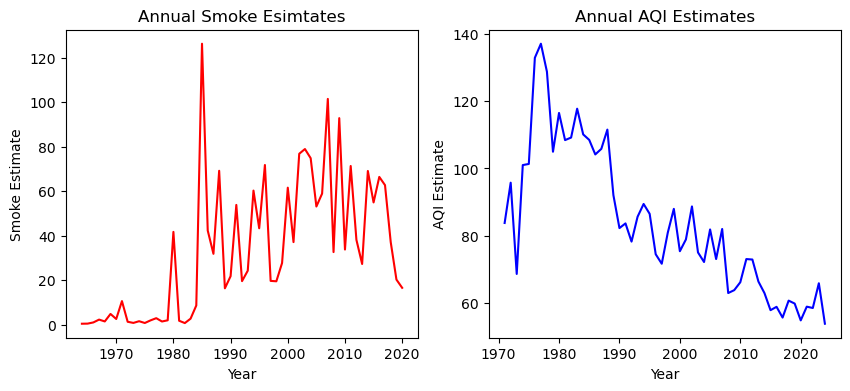

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
# plot total smoke intake
axes[0].plot(fire_annual_smoke_estimates_df[SMOKE_ESTIMATE_YEAR_COL], fire_annual_smoke_estimates_df[SMOKE_ESTIMATE_VALUE_COL], color='r')
axes[0].set_title('Annual Smoke Esimtates')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Smoke Estimate')
# Plot estimate of daily average over the years
axes[1].plot(aqi_annual_smoke_estimates_df[AQI_ESTIMATE_YEAR_COL], aqi_annual_smoke_estimates_df[AQI_ESTIMATE_VALUE_COL], color = 'b')
axes[1].set_title('Annual AQI Estimates')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('AQI Estimate')

Right off the bat, we see that the trends of Annual Smoke estimates and Annual AQI datasets are quite conflicting, with the Annual Smoke Estimates increasing over time, and the AQI values reducing over time. 

### Correlation Check

In [16]:
all_estimates_df = \
pd.merge(fire_annual_smoke_estimates_df, aqi_annual_smoke_estimates_df, 
                            left_on=SMOKE_ESTIMATE_YEAR_COL, right_on=AQI_ESTIMATE_YEAR_COL,
                            how='inner' # We remove uncommon years
    )\
    .drop(columns=[AQI_ESTIMATE_YEAR_COL])\
    .rename(columns={SMOKE_ESTIMATE_VALUE_COL: SMOKE_ESTIMATE_VALUE_COL_NEW})\
    .fillna(0)

Text(24.500000000000007, 0.5, 'AQI Estimates')

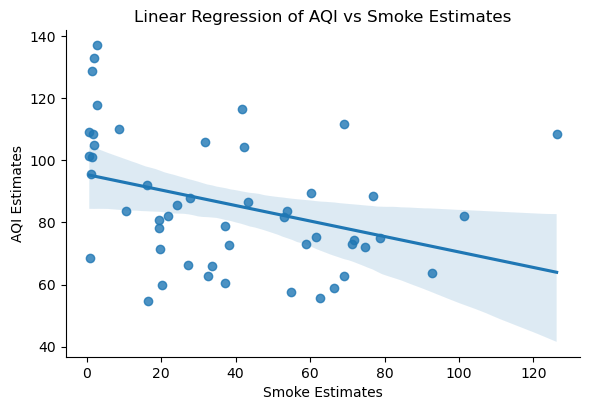

In [17]:
sns.lmplot(data=all_estimates_df, x=SMOKE_ESTIMATE_VALUE_COL_NEW, y=AQI_ESTIMATE_VALUE_COL,
           order=1, ci=95,
           height=4, aspect=1.5)
plt.title('Linear Regression of AQI vs Smoke Estimates')
plt.xlabel('Smoke Estimates')
plt.ylabel('AQI Estimates')

Owing to the fact that neither of AQI and Smoke Estimates have a normal distribution, as seen in [aqi_data_acquisition.ipynb](aqi_data_acquisition.ipynb) for AQI and [wildfire_data_acquisition.ipynb](wildfire_data_acquisition.ipynb) for Smoke Estimates, we will need to use a correlation coefficient that is robust to non-normality.

The Spearman's correlation seems like an ideal candidate to solve this issue. 

In [18]:
# Perform Spearman correlation
spearman_corr = sp.stats.spearmanr(all_estimates_df[SMOKE_ESTIMATE_VALUE_COL_NEW], all_estimates_df[AQI_ESTIMATE_VALUE_COL])
print(f'Spearman correlation: {spearman_corr.correlation}, p-value: {spearman_corr.pvalue}')

Spearman correlation: -0.38285714285714284, p-value: 0.006066793741453916


The p-value of 0.006 indicates that there is a strong evidence of there being a negative correlation between Smoke Estimates and AQI. 

In the future, we will need to revisit the smoke estimate section and re-assess the type of relationship we want between Smoke Estimates and AQI.

## Forecasting Smoke Estimates for the next 25 years

In this step, we will build a time series forecasting model focusing on smoke estimates, a single independent variable, to predict future smoke estimates. 

To begin, it’s best to check for stationarity. There are various options to test for stationarity as mentioned in this [article](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=There%20are%20various%20statistical%20tests,unit%20root%20in%20the%20data.). Of the tests mentioned in the article, we will use the `Augmented Dickey-Fuller Test`. 

In [19]:
# IMPORTS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [20]:
# CONSTANTS
FORECASTED_SMOKE_ESTIMATES_PATH = "final/forecasted_smoke_estimates.csv"

In [21]:
# Run test
adftest = adfuller(fire_annual_smoke_estimates_df[SMOKE_ESTIMATE_VALUE_COL], autolag='AIC')
print(adftest)

(-2.7533148539137904, 0.06525803733856035, 1, 55, {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}, 432.11222507127343)


In [22]:
adftest_output = dict()
adftest_output["Test Statistic"] = adftest[0]
adftest_output["p-value"] = adftest[1]
adftest_output["Number of Lags Used"] = adftest[2]
adftest_output["Number of Observations Used"] = adftest[3]

for key,value in adftest[4].items():
    adftest_output[f"Critical Value ({key})"] = value

# Print the results
print("Augmented Dickey-Fuller test results:")
for key, value in adftest_output.items():
    print(f"{key}: {value}")

Augmented Dickey-Fuller test results:
Test Statistic: -2.7533148539137904
p-value: 0.06525803733856035
Number of Lags Used: 1
Number of Observations Used: 55
Critical Value (1%): -3.5552728880540942
Critical Value (5%): -2.9157312396694217
Critical Value (10%): -2.5956695041322315


The Augmented Dickey-Fuller test concludes with high confidence that the distribution is stationary. This is a favorable condition for applying autoregressive models like ARIMA, as stationarity is often a key requirement for accurate time series forecasting.

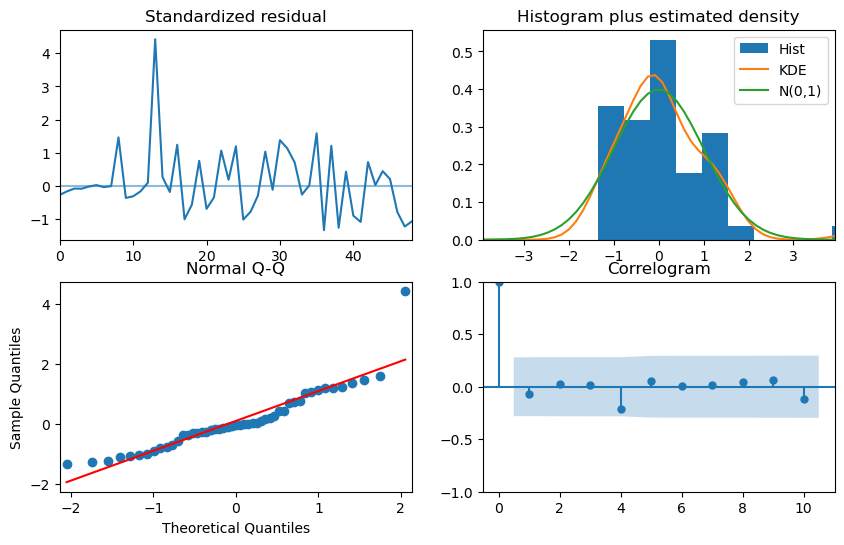

In [23]:
ARIMA_model = pm.auto_arima(all_estimates_df[SMOKE_ESTIMATE_VALUE_COL_NEW], 
                      start_p=0, start_q=0, max_p=10, max_q=10,
                      m=1, d=None,
                      test='adf',
                      seasonal=False, 
                      trace=False,
                      error_action='warn',
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(10, 6))
plt.show()

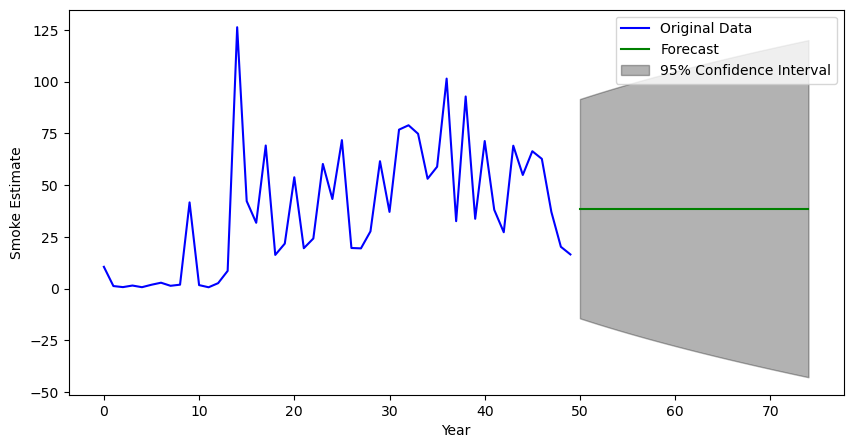

In [24]:
# Forecast future values for the next 25 years
forecast, conf_int = ARIMA_model.predict(n_periods=25, return_conf_int=True)

forecast_series = pd.Series(forecast)
lower_conf_int_series = pd.Series(conf_int[:, 0], index=forecast_series.index)
upper_conf_int_series = pd.Series(conf_int[:, 1], index=forecast_series.index)

# Plot forecast
fig = plt.figure(figsize=(10,5))
plt.plot(all_estimates_df[SMOKE_ESTIMATE_VALUE_COL_NEW], color='b', label = 'Original Data')
plt.plot(forecast_series, color='g', label = "Forecast")
plt.xlabel("Year")
plt.ylabel("Smoke Estimate")
plt.fill_between(lower_conf_int_series.index, 
                lower_conf_int_series, 
                upper_conf_int_series, 
                color='k', alpha=.30 , label = "95% Confidence Interval")
plt.legend(loc="upper right")
plt.show()

As one can see, this is not a very promising estimate, due to being almost constant across the years.

In the future, we will come back to this. We will possibly be considering additional exogenous variables (like fire counts or area burned), and thus can use better models, such as ARIMAX, a version of ARIMA that includes external factors.

## Visual Analysis

### Part 1

We produce a histogram showing the number of fires occurring every 50 mile distance from Indianapolis for all fires ranging up to 1800 miles away from Indianapolis. The histogram indicates the distance cut-off for the modeling work

In [25]:
# IMPORTS

In [26]:
# CONSTANTS
DISTANCE_THRESHOLD = 1800 # in miles
DISTANCE_THRESHOLD_ANALYIS = 650 # in miles

FIRE_FEATURE_DISTANCES_PATH = "intermediate/Fire_Feature_Distances.csv"

FIRE_YEAR_COLUMN = "Fire_Year"
FIRE_DISTANCE_COLUMN = "Distance"
FIRE_TYPE_COLUMN = "Assigned_Fire_Type"

In [27]:
# During the Wildfire Data Acquisition, we had saved the fire data along with distances from Indianapolis
fire_feature_valid_dates_df = pd.read_csv(FIRE_FEATURE_DISTANCES_PATH)

/var/folders/yd/c7lfj7x549724qswqhxskfz40000gn/T/ipykernel_36979/3888073153.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  fire_feature_valid_dates_df = pd.read_csv(FIRE_FEATURE_DISTANCES_PATH)


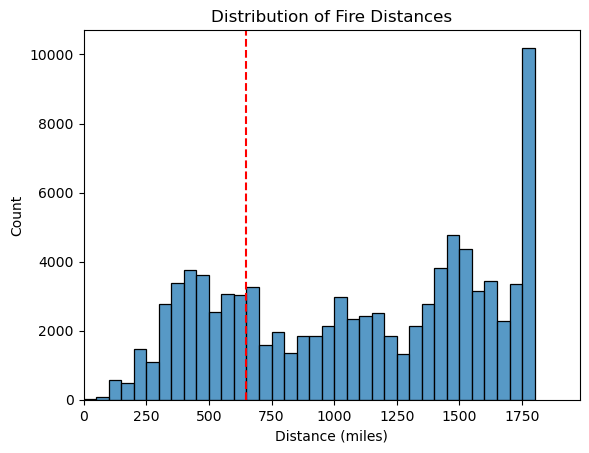

In [28]:
# Use seaborn's histplot to visualize the distribution of distances upto 1800 miles
sns.histplot(data=fire_feature_valid_dates_df, 
             x=FIRE_DISTANCE_COLUMN, bins=range(0, DISTANCE_THRESHOLD+1, 50), 
             multiple="stack", stat="count")
plt.title('Distribution of Fire Distances')
plt.xlabel('Distance (miles)')
plt.ylabel('Count')
plt.xlim(0, DISTANCE_THRESHOLD*1.1)

# Indicate the distance cut-off for modeling work (DISTANCE_THRESHOLD_ANALYIS)
plt.axvline(x=DISTANCE_THRESHOLD_ANALYIS, color='red', linestyle='--', label='Distance Threshold for Analysis')

plt.show()

### Part 2

We produce a time series graph of total acres burned per year for the fires occurring in the specified distance from Indianapolis.

In [29]:
# CONSTANTS
ACRES_COLUMN = "GIS_Acres"

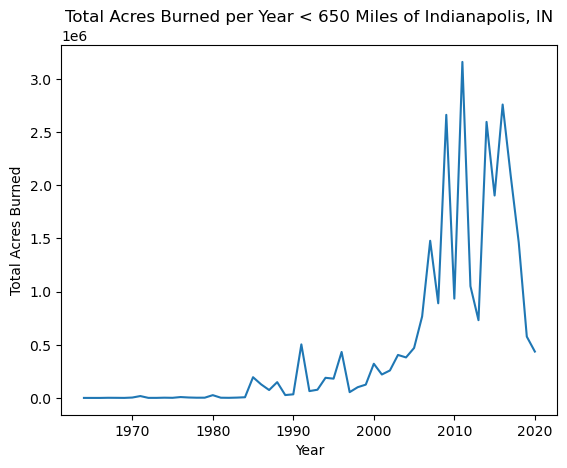

In [30]:
# Group filtered_fire_features_gdf by year and sum the acres burned
acres_burned_per_year_df = filtered_fire_features_gdf[[FIRE_YEAR_COLUMN, ACRES_COLUMN]]\
    .groupby(FIRE_YEAR_COLUMN)[ACRES_COLUMN].sum().reset_index()
sns.lineplot(data=acres_burned_per_year_df, x=FIRE_YEAR_COLUMN, y=ACRES_COLUMN)
plt.title('Total Acres Burned per Year < 650 Miles of Indianapolis, IN')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.show()

### Part 3

We produce a time series graph containing the fire smoke estimates and the AQI estimates for Indianapolis, IN.

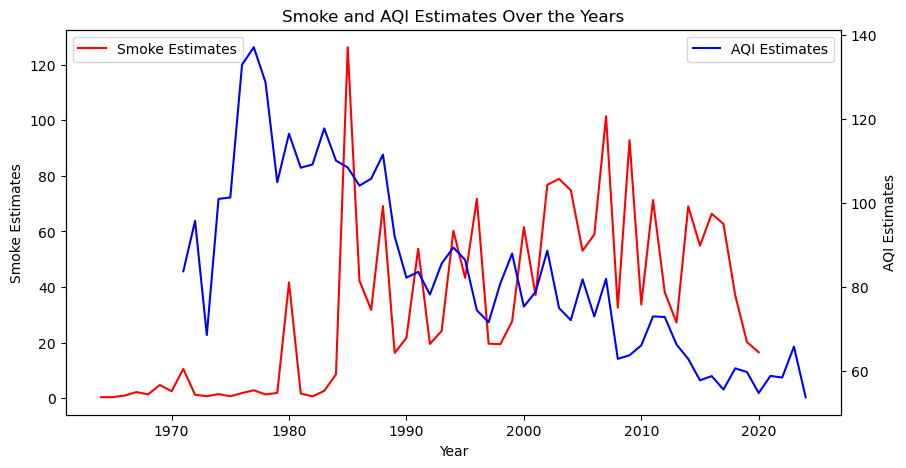

In [31]:
fig = plt.figure(figsize=(10, 5))
# Plot Smoke Estimates
ax = sns.lineplot(data=fire_annual_smoke_estimates_df, x=SMOKE_ESTIMATE_YEAR_COL, y=SMOKE_ESTIMATE_VALUE_COL, 
                  color='r', label='Smoke Estimates')
ax2 = ax.twinx()
# Plot AQI Estimates
sns.lineplot(data=aqi_annual_smoke_estimates_df, x=AQI_ESTIMATE_YEAR_COL, y=AQI_ESTIMATE_VALUE_COL, 
             color='b', ax=ax2, label='AQI Estimates')
ax.set_title('Smoke and AQI Estimates Over the Years')
ax.set_xlabel('Year')
ax.set_ylabel('Smoke Estimates')
ax2.set_ylabel('AQI Estimates')

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()